In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('datasets/train.csv')
print(df.head())

   stock_id  date_id  seconds_in_bucket  imbalance_size   
0         0        0                  0      3180602.69  \
1         1        0                  0       166603.91   
2         2        0                  0       302879.87   
3         3        0                  0     11917682.27   
4         4        0                  0       447549.96   

   imbalance_buy_sell_flag  reference_price  matched_size  far_price   
0                        1         0.999812   13380276.64        NaN  \
1                       -1         0.999896    1642214.25        NaN   
2                       -1         0.999561    1819368.03        NaN   
3                       -1         1.000171   18389745.62        NaN   
4                       -1         0.999532   17860614.95        NaN   

   near_price  bid_price  bid_size  ask_price   ask_size  wap    target   
0         NaN   0.999812  60651.50   1.000026    8493.03  1.0 -3.029704  \
1         NaN   0.999896   3233.04   1.000660   20605.09  1.0 

In [3]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5237980 entries, 0 to 5237979
Data columns (total 17 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   stock_id                 int64  
 1   date_id                  int64  
 2   seconds_in_bucket        int64  
 3   imbalance_size           float64
 4   imbalance_buy_sell_flag  int64  
 5   reference_price          float64
 6   matched_size             float64
 7   far_price                float64
 8   near_price               float64
 9   bid_price                float64
 10  bid_size                 float64
 11  ask_price                float64
 12  ask_size                 float64
 13  wap                      float64
 14  target                   float64
 15  time_id                  int64  
 16  row_id                   object 
dtypes: float64(11), int64(5), object(1)
memory usage: 679.4+ MB
None


In [4]:
# Fix given stock_id

unique_stocks = df['stock_id'].unique()

first_stock_id = unique_stocks[0]
second_stock_id = unique_stocks[1]
# Filter the DataFrame to only include rows with the first stock_id

df_first_stock = df[df['stock_id'] == first_stock_id]
df_second_stock = df[df['stock_id'] == second_stock_id]

print(f"First stock_id: {first_stock_id}")
print(f"Second stock_id: {second_stock_id}")
print(f"First stock_id size: {df_first_stock.shape}")
print(f"Second stock_id size: {df_second_stock.shape}")

First stock_id: 0
Second stock_id: 1
First stock_id size: (26455, 17)
Second stock_id size: (26455, 17)


In [5]:
df_first_stock.isna().sum()

stock_id                       0
date_id                        0
seconds_in_bucket              0
imbalance_size                 0
imbalance_buy_sell_flag        0
reference_price                0
matched_size                   0
far_price                  14517
near_price                 14430
bid_price                      0
bid_size                       0
ask_price                      0
ask_size                       0
wap                            0
target                         0
time_id                        0
row_id                         0
dtype: int64

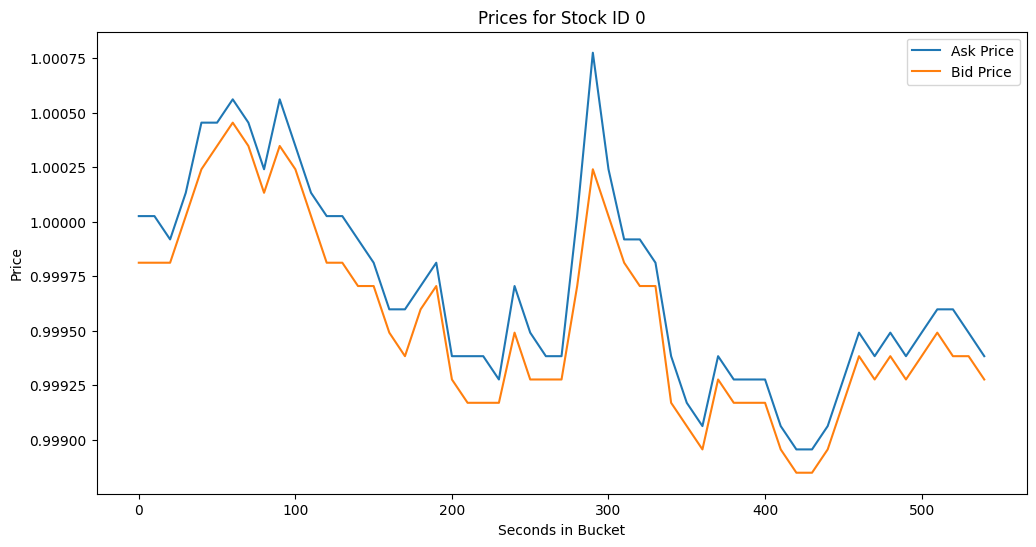

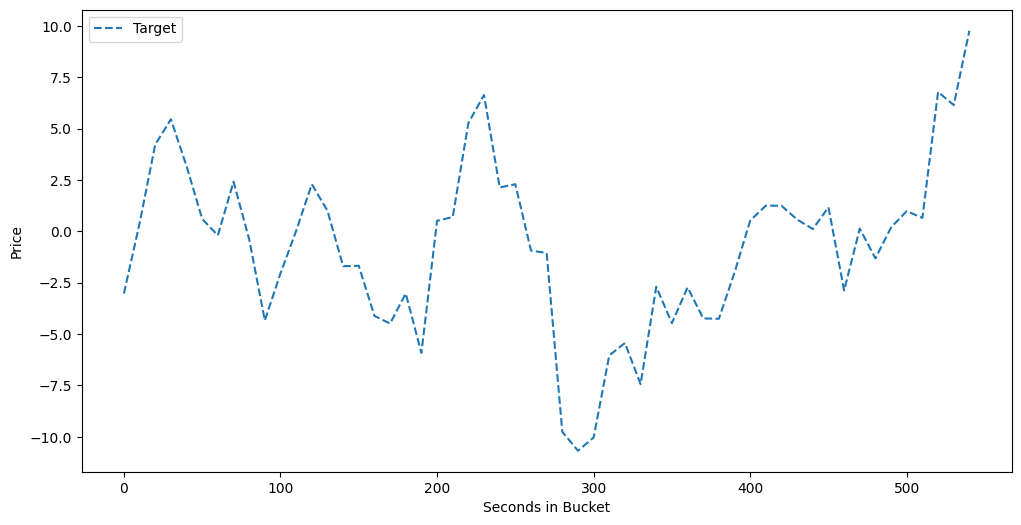

In [11]:
# plot the ask_price and bid_price in the first day
def plot_prices(df, stock_id, day=0):
    df_stock = df[(df['stock_id'] == stock_id) & (df['date_id'] == day)]

    plt.figure(figsize=(12, 6))

    plt.plot(df_stock['seconds_in_bucket'], df_stock['ask_price'], label='Ask Price')
    plt.plot(df_stock['seconds_in_bucket'], df_stock['bid_price'], label='Bid Price')
    plt.title(f'Prices for Stock ID {stock_id}')
    plt.xlabel('Seconds in Bucket')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(df_stock['seconds_in_bucket'], df_stock['target'], label='Target', linestyle='--')
    plt.xlabel('Seconds in Bucket')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

plot_prices(df, first_stock_id, day=0)

In [8]:
first_stock_diff = df_first_stock['ask_price'].diff().fillna(0)
second_stock_diff = df_second_stock['ask_price'].diff().fillna(0)

np.corrcoef(first_stock_diff, second_stock_diff)

array([[1.        , 0.29308592],
       [0.29308592, 1.        ]])

In [9]:
# first price everyday
def compute_daily_return(df, stock_id):
    df_stock = df[df['stock_id'] == stock_id]
    stock_first_price = df_stock.groupby('date_id')['ask_price'].first()
    stock_last_price = df_stock.groupby('date_id')['ask_price'].last()
    stock_daily_return = (stock_last_price - stock_first_price) / stock_first_price
    return stock_daily_return


first_stock_daily_return = compute_daily_return(df, first_stock_id)
second_stock_daily_return = compute_daily_return(df, second_stock_id)

print(first_stock_daily_return.head())
print(second_stock_daily_return.head())

np.corrcoef(first_stock_daily_return, second_stock_daily_return)

date_id
0   -0.000643
1   -0.001181
2   -0.001411
3   -0.001952
4   -0.000103
Name: ask_price, dtype: float64
date_id
0    0.000588
1    0.001971
2   -0.002954
3    0.002559
4    0.001132
Name: ask_price, dtype: float64


array([[1.        , 0.39578254],
       [0.39578254, 1.        ]])

In [12]:
# little bit of regeression

from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

In [31]:
X = df_first_stock.dropna(axis=1)
print(X.isna().sum())

stock_id                   0
date_id                    0
seconds_in_bucket          0
imbalance_size             0
imbalance_buy_sell_flag    0
reference_price            0
matched_size               0
bid_price                  0
bid_size                   0
ask_price                  0
ask_size                   0
wap                        0
target                     0
time_id                    0
row_id                     0
dtype: int64


In [32]:
limit_date = int(max(X['date_id']) * 0.8)

X_train = X.loc[X['date_id'] <= limit_date]
X_test = X.loc[X['date_id'] > limit_date]   

y_train = X_train['target']
y_test = X_test['target']
X_train = X_train.drop(columns=['target', 'stock_id', 'date_id', 'row_id'])
X_test = X_test.drop(columns=['target', 'stock_id', 'date_id', 'row_id'])

model = LinearRegression()

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Linear Regression MSE:", mean_squared_error(y_test, y_pred))

r2 = r2_score(y_test, y_pred)
print("Linreg R^2:", r2)

Linear Regression MSE: 29.70624848951685
Linreg R^2: 0.02083182072816614


In [33]:
print(X_train.dtypes)

seconds_in_bucket            int64
imbalance_size             float64
imbalance_buy_sell_flag      int64
reference_price            float64
matched_size               float64
bid_price                  float64
bid_size                   float64
ask_price                  float64
ask_size                   float64
wap                        float64
time_id                      int64
dtype: object


In [34]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for XGBoost
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3, verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=42, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7], 'n_estimators': [100, 200],
                         'subsample': [0.8, 1.0]},
             scoring='neg_mean_squared_error', verbose=1)

In [35]:
grid_search.best_params_
best_model = grid_search.best_estimator_

In [36]:
y_pred = best_model.predict(X_test)
print("XGBoost MSE:", mean_squared_error(y_test, y_pred))

XGBoost MSE: 30.185166103930467


In [37]:
r2 = r2_score(y_test, y_pred)
print("XGBOOST R^2:", r2)

XGBOOST R^2: 0.005045886375261266
